# NLP sentiment text generator

## Setup environment and libraries

In [95]:
SEED = 0

In [96]:
!pip install -U spacy
!python -m spacy download es_core_news_md

Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.6)
2021-06-27 18:21:25.651746: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [97]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import spacy
import nltk
import time
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from sklearn.manifold import TSNE

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import classification_report

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

Check whether a GPU is able

In [98]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load datasets

### 15 maximum word dataset

In [100]:
emotions_df = pd.read_csv('app_records_word_freq_cleaned.csv')
emotions_df.emotion_text = emotions_df.emotion_text.astype(str)
emotions_df

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
0,10,2019-05-04,levantar comer,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.1500,398.0,720.0,32400.0,22.0,0.0,8090.0,0.0,20588.0,55.0,5157.0,20603.0,0.0,0.0,2398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003554,70200.0,0.0,0.0,0.0,6.0
1,10,2019-05-05,hoy despertar pero no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.9200,2491.0,3986.0,28800.0,28.0,0.0,2620.0,0.0,20836.0,889.0,2118.0,11749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001379,75600.0,0.0,0.0,0.0,6.0
2,10,2019-05-06,no comer noche,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.2000,1111.0,1773.0,28800.0,30.0,0.0,8200.0,0.0,24300.0,280.0,8139.0,9901.0,0.0,0.0,4113.0,0.0,0.0,0.0,3109.0,0.0,0.0,0.012274,64800.0,0.0,0.0,0.0,15.0
3,10,2019-05-07,no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,28.5104,17.0,3866.0,28800.0,38.0,0.0,8520.0,0.0,42604.0,1577.0,12109.0,16635.0,0.0,0.0,4997.0,0.0,0.0,0.0,742.0,2.0,0.0,0.000012,30600.0,0.0,0.0,0.0,2.0
4,10,2019-05-20,viaje,0,0,0,1,0,0,0,0,0,0,0,0,0,4909.5400,8.0,1824.0,11958.0,0.0,0.0,4044.0,0.0,20178.0,519.0,7841.0,16960.0,0.0,0.0,4207.0,0.0,0.0,0.0,30.0,0.0,0.0,0.000013,34200.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5156,2690,2020-03-11,día,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0000,0.0,0.0,25800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4.0,0.0,0.0,0.0
5157,2690,2020-03-23,niña discutir,1,0,0,0,0,0,1,0,0,0,0,0,0,0.0000,0.0,0.0,23400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.0,0.0,0.0,0.0
5158,2690,2020-03-23,niña,1,0,0,0,0,0,1,0,0,0,0,0,0,0.0000,0.0,0.0,23400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.0,0.0,0.0,0.0
5159,2690,2020-03-27,trabajo,1,0,0,0,0,0,0,0,0,1,0,0,0,641.4610,0.0,5413.0,42000.0,0.0,0.0,0.0,0.0,0.0,5295.0,0.0,28367.0,0.0,554.0,608.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.0,1.0,0.0,554.0,0.0


In [101]:
pie_chart_df = emotions_df.groupby("sad").count().rename(columns={'date': 'Sentiment'},
                                                              index={0: 'happy',
                                                                     1: 'sad'})

In [102]:
pie_chart_df

,id,Sentiment,emotion_text,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
sad,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
happy,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044
sad,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117


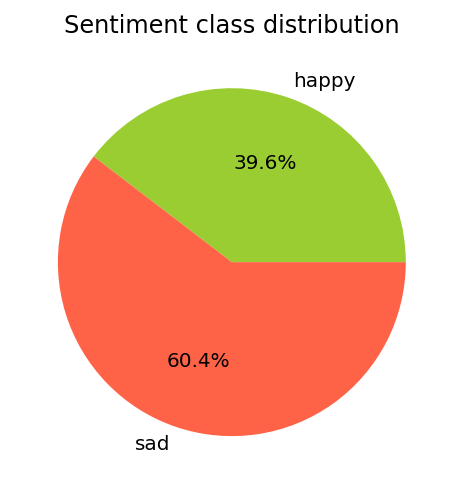

In [103]:
fig = pie_chart_df.Sentiment.plot.pie(title='Sentiment class distribution',
                            ylabel='', autopct='%1.1f%%', 
                            colormap=ListedColormap(['yellowgreen', 'tomato']))
plt.savefig('nlp_sad_records.png', dpi=300)

## Data arrangement

SOS and EOS tags creation

In [12]:
nlp = spacy.load('es_core_news_md')

Check that do not exist right now. 

In [13]:
print(f'SOS in vocab: {nlp.vocab.has_vector("<sos>")}')
print(f'EOS in vocab: {nlp.vocab.has_vector("<eos>")}')

SOS in vocab: False
EOS in vocab: False


We add for the tokenizer the tags. 

In [14]:
nlp.tokenizer.add_special_case('<sos>', [{spacy.symbols.ORTH: "<sos>"}])
nlp.tokenizer.add_special_case('<eos>', [{spacy.symbols.ORTH: "<eos>"}])

In [15]:
doc = nlp('<sos> Hola que tal estas <eos>')
for token in doc:
    print(token.text, token.pos_, token.dep_)

<sos> NUM ROOT
Hola PROPN flat
que SCONJ mark
tal PRON det
estas PRON fixed
<eos> NUM conj


Creates the new vectors and links them to the <sos> and <eos> tags. 

In [16]:
np.random.seed(SEED)
sos_vector = np.random.rand(300).astype(np.float32)
eos_vector = np.random.rand(300).astype(np.float32)
nlp.vocab.set_vector('<sos>', sos_vector)
nlp.vocab.set_vector('<eos>', eos_vector)
print(f'SOS in vocab: {nlp.vocab.has_vector("<sos>")}')
print(f'EOS in vocab: {nlp.vocab.has_vector("<eos>")}')

SOS in vocab: True
EOS in vocab: True


In [17]:
print(sos_vector[:5])
print(nlp.vocab.get_vector('<sos>')[:5])
print(eos_vector[:5])
print(nlp.vocab.get_vector('<eos>')[:5])

[0.5488135  0.71518934 0.60276335 0.5448832  0.4236548 ]
[0.5488135  0.71518934 0.60276335 0.5448832  0.4236548 ]
[0.9065555  0.7740473  0.33314514 0.08110139 0.40724117]
[0.9065555  0.7740473  0.33314514 0.08110139 0.40724117]


It returns a DataFrame with all the field, including the emotion text field with the <SOS> and the <EOS> tags and regularized.

In [18]:
def add_eos_sos_tags(text):
    words = text.split(' ')
    words.insert(0, '<sos>')
    words.append('<eos>')
    return ' '.join(words)

In [19]:
def regularize_text(max_words, text):
    words = text.split(' ')
    len_words = len(words)
    if (len_words < max_words):
        eos = ['<eos>'] * (max_words - len_words)
        words = words + eos
    return ' '.join(words)

In [20]:
def obtain_n_rows_from_sentence(word2row, text):
    words = text.split(' ')
    rows = [word2row[w] for w in words]
    return rows

In [21]:
def obtain_words_from_rows(rows_array):
    words = [[row2word[rows_array[i, j]] \
              for j in range(rows_array.shape[1])] \
                          for i in range(rows_array.shape[0])]
    return np.array(words)

In [22]:
def arrange_data(df):
    # Compute maximum number of words
    df_aux = df.copy()
    # First, we add the tags
    emotion_texts = df_aux['emotion_text']
    emotion_texts_tags = emotion_texts.apply(lambda x: add_eos_sos_tags(x))
    # Then, compute the words used
    df_aux['words_used'] = emotion_texts_tags.apply(lambda x: len(x.split()))
    # Then, compute the maximum words 
    max_words = len(max(emotion_texts_tags, key=lambda x: len(x.split())).split())
    print('The maximum number of words in a text:', max_words)
    emotion_texts_reg = emotion_texts_tags\
                                .apply(lambda x: regularize_text(max_words, x))
    df_aux['emotion_text_reg'] = emotion_texts_reg    

    vocab = set(df_aux.emotion_text_reg.str.cat(sep=' ').split(' '))
    print('Number of words in the vocabulary:', len(vocab))
    word2row = {w: i for i, w in enumerate(vocab)}
    row2word = {i: w for i, w in enumerate(vocab)}
    word_embed = np.zeros((len(vocab), 300), dtype=np.float32)
    for i, w in enumerate(vocab):
        word_embed[i] = nlp.vocab.get_vector(w)
    
    text_row_regular = df_aux.emotion_text_reg.\
        apply(lambda x: obtain_n_rows_from_sentence(word2row, x))

    df_aux['emotion_text_row'] = text_row_regular

    return df_aux, word2row, row2word, word_embed

In [23]:
emotions_df_reg, word2row, row2word, word_embed = arrange_data(emotions_df)

The maximum number of words in a text: 17
Number of words in the vocabulary: 425


In [24]:
emotions_df_reg.head(3)

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count,words_used,emotion_text_reg,emotion_text_row
0,10,2019-05-04,levantar comer,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.15,398.0,720.0,32400.0,22.0,0.0,8090.0,0.0,20588.0,55.0,5157.0,20603.0,0.0,0.0,2398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003554,70200.0,0.0,0.0,0.0,6.0,4,<sos> levantar comer <eos> <eos> <eos> <eos> <...,"[161, 82, 223, 256, 256, 256, 256, 256, 256, 2..."
1,10,2019-05-05,hoy despertar pero no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.92,2491.0,3986.0,28800.0,28.0,0.0,2620.0,0.0,20836.0,889.0,2118.0,11749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001379,75600.0,0.0,0.0,0.0,6.0,7,<sos> hoy despertar pero no comer <eos> <eos> ...,"[161, 138, 370, 395, 393, 223, 256, 256, 256, ..."
2,10,2019-05-06,no comer noche,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.20,1111.0,1773.0,28800.0,30.0,0.0,8200.0,0.0,24300.0,280.0,8139.0,9901.0,0.0,0.0,4113.0,0.0,0.0,0.0,3109.0,0.0,0.0,0.012274,64800.0,0.0,0.0,0.0,15.0,5,<sos> no comer noche <eos> <eos> <eos> <eos> <...,"[161, 393, 223, 282, 256, 256, 256, 256, 256, ..."


X and Y are matrix with the word row number already regularized. 

In [25]:
text_rows = emotions_df_reg['emotion_text_row']
text_rows = np.array(text_rows.values.tolist())
X = torch.LongTensor(text_rows)
Y = X[:, 1:]
X = X[:, :-1]

# Get the app records measures
app_cols = emotions_df_reg.columns[16:-3]
app_records = emotions_df_reg[app_cols]
X_app = torch.FloatTensor(app_records.values)

words2pred = torch.LongTensor(emotions_df_reg['words_used'].values - 1) 
word_embed = torch.FloatTensor(word_embed)
record_ids = np.arange(emotions_df_reg.shape[0])

In [26]:
print(X.shape)
print(Y.shape)

torch.Size([5161, 16])
torch.Size([5161, 16])


In [27]:
print(words2pred)

tensor([3, 6, 4,  ..., 2, 2, 2])


## Dataset implementation and initialization

In [28]:
class EmotionDataset(Dataset):

    def __init__(self, x_words_row, y_words_row, x_app_vector, n_words_predict,
                 record_ids):        
        self.x_words_row = x_words_row
        self.y_words_row = y_words_row
        self.x_app_vector = x_app_vector
        self.n_words_predict = n_words_predict
        self.record_ids = record_ids

    def get_sequence(self, idxs):
        return (
            self.x_words_row[idxs],
            self.y_words_row[idxs],
            self.x_app_vector[idxs],
            self.n_words_predict[idxs],
            self.record_ids[idxs]
        )

    def __size__(self):
        return self.x_words_row.shape[0]

    def __len__(self):
        return self.x_words_row.shape[0]
    
    def __getitem__(self, idx):
        return (
            self.x_words_row[idx],
            self.y_words_row[idx],
            self.x_app_vector[idx],
            self.n_words_predict[idx],
            self.record_ids[idx]
        )


In [29]:
def train_test_split(emotion_dataset, test_size=0.2, shuffle=True):
    total_rows = len(emotion_dataset)
    test_rows = int(total_rows*test_size)
    train_rows = total_rows - test_rows
    if shuffle:
        permutation = np.random.default_rng(SEED).permutation(total_rows)
    else:
        permutation = np.arange(total_rows)
    train_idxs = permutation[:train_rows]
    test_idxs = permutation[train_rows:]
    emotion_train = emotion_dataset.get_sequence(train_idxs)
    emotion_train_dataset = EmotionDataset(*emotion_train)
    emotion_test = emotion_dataset.get_sequence(test_idxs)
    emotion_test_dataset = EmotionDataset(*emotion_test)
    return (emotion_train_dataset, emotion_test_dataset)

In [30]:
emotion_dataset = EmotionDataset(x_words_row=X, 
                                 y_words_row=Y,
                                 x_app_vector=X_app, 
                                 n_words_predict=words2pred,
                                 record_ids=record_ids)

In [31]:
emotion_train, emotion_test = train_test_split(emotion_dataset)

In [32]:
emotion_train, emotion_val = train_test_split(emotion_train)

In [33]:
train_loader = DataLoader(emotion_train, batch_size=64, 
                             shuffle=True)
val_loader = DataLoader(emotion_val, batch_size=64, 
                             shuffle=True)
test_loader = DataLoader(emotion_test, batch_size=64, 
                             shuffle=True)

## LSTM standard model

### Class implementation

In [104]:
class EmotionTextLSTMStandard(nn.Module):


    def __init__(self, lstm_num_layers, app_dim, word_embedding, 
                 word2row, row2word, dropout_p, freeze_embedding):

        # word_vector_size -> word vector dimension
        # number of the embedding_dimension (not sure)
        # nlp -> the spaCy instance with <EOS> and <SOS> tokens
        
        # The main variables to save
        # super(GRU, self).__init__()
        super().__init__()
        self.app_vector_dim = app_dim
        self.dropout_p = dropout_p

        # The embedding with some auxiliary variables
        self.embed_weights = word_embedding
        self.word2row = word2row
        self.row2word = row2word
        self.embed_dim = self.embed_weights.shape[1]
        self.n_vocab = self.embed_weights.shape[0]
        self.freeze_embedding = freeze_embedding
        self.lstm_num_layers = lstm_num_layers
        self.embedding = nn.Embedding.from_pretrained(self.embed_weights, 
                                                      freeze=self.freeze_embedding)
        
        # A DNN to put the hidden state in correct state
        self.fc_hidden_state = nn.Linear(self.app_vector_dim, 
                                         self.embed_dim*self.lstm_num_layers)
        self.sigmoid = nn.Sigmoid()
        #self.sigmoid = nn.Tanh()
        
        # Batch is first, so:
        # the input must be (Batch size, Sequence length=16, Input size=300)
        self.lstm = nn.LSTM(input_size=self.embed_dim, 
                            hidden_size=self.embed_dim, 
                            num_layers=self.lstm_num_layers,
                            batch_first=True)
        self.fcout = nn.Linear(self.embed_dim, self.n_vocab)
        self.logsoftmax = nn.LogSoftmax(dim=2)
        self.dropout = nn.Dropout(self.dropout_p)
    

    # X: word rows in the dictionary
    def forward(self, X, states=None, X_app=None):

        if not X.is_cuda:
            X = X.to(device)

        if (X_app is not None) and (states is None):
            if not X_app.is_cuda:
                X_app = X_app.to(device)
            hidden = self.dropout(self.sigmoid(self.fc_hidden_state(X_app)))
            hidden = hidden.view(self.lstm_num_layers, -1, self.embed_dim)
            cell = torch.zeros(self.lstm_num_layers, 
                               X_app.shape[0], self.embed_dim).to(device)

        output = self.embedding(X).view(X.shape[0], -1, self.embed_dim)
        
        output, (hidden, cell) = self.lstm(output, (hidden, cell))

        output = self.dropout(output)

        output = self.fcout(output)
        output = self.logsoftmax(output)

        return output, (hidden, cell)

In [105]:
lstm = EmotionTextLSTMStandard(lstm_num_layers=1, app_dim=X_app.shape[1], 
                               word_embedding=word_embed, word2row=word2row, 
                               row2word=row2word, dropout_p=0.3, 
                               freeze_embedding=True)
lstm.to(device)

EmotionTextLSTMStandard(
  (embedding): Embedding(425, 300)
  (fc_hidden_state): Linear(in_features=27, out_features=300, bias=True)
  (sigmoid): Sigmoid()
  (lstm): LSTM(300, 300, batch_first=True)
  (fcout): Linear(in_features=300, out_features=425, bias=True)
  (logsoftmax): LogSoftmax(dim=2)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [106]:
output, _ = lstm.forward(X, states=None, X_app=X_app)

### Training implementation

In [107]:
class EmotionTextLSTMStandard_extended(EmotionTextLSTMStandard):


    def __init__(self, lstm_num_layers, app_dim, word_embedding, word2row, 
                 row2word, dropout_p, freeze_embedding, epochs=100, lr=0.01):
        
        super().__init__(lstm_num_layers, app_dim, word_embedding, 
                         word2row, row2word, dropout_p, freeze_embedding)

        self.lr = lr
        
        self.criterion = nn.NLLLoss()
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.file_weight_name = ''

        self.loss_during_training = []
        self.loss_val_during_training = []
    

    def fit(self, train_loader, val_loader, max_stop=None,
            file_weight_name='lstm_standard_checkpoint'):  
        
        words2pred, _, _, _, _ = next(iter(train_loader))
        words2pred = words2pred.shape[1]

        min_val_epoch_loss = float('inf')
        min_val_epoch = 0
        no_impr = 0

        n_train = train_loader.dataset.n_words_predict.shape[0]
        n_val = val_loader.dataset.n_words_predict.shape[0]

        self.file_weight_name = 'checkpoints/' + file_weight_name \
                        + '_'+ str(self.lstm_num_layers) + '_layers' + '.pth'

        for e in range(self.epochs):

            loss_epoch = 0

            self.train()
            for X_batch_train, Y_batch_train, \
                X_batch_app_train, X_batch_w2pred_train, _ in train_loader: 

                self.optim.zero_grad()
                loss = 0

                # To GPU
                X_batch_train = X_batch_train.to(device)
                Y_batch_train = Y_batch_train.to(device)
                X_batch_app_train = X_batch_app_train.to(device)
                X_batch_w2pred_train = X_batch_w2pred_train.to(device)

                output, _ = self.forward(X=X_batch_train,
                                      X_app=X_batch_app_train,
                                      states=None)

                # For each output observation of the batch, 
                # we compute the NLLLoss
                for i in range(X_batch_train.shape[0]):
                    n_words = X_batch_w2pred_train[i]
                    loss += self.criterion(output[i, :n_words], 
                                           Y_batch_train[i, :n_words])

                loss.backward()

                # This code helps to avoid vanishing exploiting gradients in RNNs
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                self.optim.step()
            
                loss_epoch += loss

            loss_epoch = loss_epoch / n_train
            self.loss_during_training.append(loss_epoch.item())
            self.eval()
            val_loss_epoch = self.validation_loss(val_loader) / n_val
            self.loss_val_during_training.append(val_loss_epoch)
            
            if e % 10 == 0:
                print('[Train]: Epoch %d -> Train loss: %f - Val loss: %f' 
                      % (e, loss_epoch, val_loss_epoch))
        
            if val_loss_epoch < min_val_epoch_loss:
                min_val_epoch_loss = val_loss_epoch
                min_val_epoch = e
                #print('[Train]: Best model obtained so far: saving weights...')
                torch.save(self.state_dict(), self.file_weight_name)
                #print('[Train]: Val error: %f in epoch %d'%(val_loss_epoch, e))       
                if max_stop is not None:
                    no_impr = 0
            else:
                if max_stop is not None:
                    no_impr += 1
                    if no_impr > max_stop:
                        print('[Train]: Training stopped in epoch %d. No improvement for %d epochs' % (e, max_stop))
                        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
                            % (min_val_epoch, min_val_epoch_loss))    
                        return
        
        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
        % (min_val_epoch, min_val_epoch_loss))    

            
    def validation_loss(self, val_loader): 

        loss_val = 0

        self.eval()

        words2pred, _, _, _, _ = next(iter(val_loader))
        words2pred = words2pred.shape[1]
        
        with torch.no_grad(): 

            for X_batch_val, Y_batch_val, \
                X_batch_app_val, X_batch_w2pred_val, _ in val_loader: 

                X_batch_val = X_batch_val.to(device)
                Y_batch_val = Y_batch_val.to(device)
                X_batch_app_val = X_batch_app_val.to(device)
                X_batch_w2pred_val = X_batch_w2pred_val.to(device)
                
                output, _ = self.forward(X=X_batch_val, 
                                      X_app=X_batch_app_val,
                                      states=None)
                
                for i in range(X_batch_val.shape[0]):
                    n_words = X_batch_w2pred_val[i]
                    loss_val += self.criterion(output[i, :n_words], 
                                               Y_batch_val[i, :n_words])
                    
        return loss_val.item()


    def obtain_word(self, out_numpy):
        word_row = np.argmax(out_numpy)
        return self.row2word[word_row]

    
    def obtain_words(self, outs, take=1):
        # word_rows = np.argmax(outs, axis=1)
        word_rows = np.argsort(outs, axis=1)[::-1]
        word_rows = word_rows[:, :take]
        words = [[self.row2word[w] for w in w_cand if self.row2word[w] != '<sos>'] for w_cand in word_rows]
        #words_no_rep = set(w for subl in words for w in subl)
        # This is just to obtain the words with no repetitions
        # an put the <eos> in the last part
        #words_no_rep = list(set(words))
        #words_no_rep = list(words_no_rep)
        words_no_rep = words
        '''if '<eos>' in words_no_rep:
            words_no_rep.remove('<eos>')
        words_no_rep.append('<eos>')'''
        return words_no_rep

    
    def obtain_words_stochastic(self, outs):
        self.eval()
        outs = np.exp(outs)
        rng = np.random.default_rng(seed=SEED)
        rows = [rng.choice(self.n_vocab, 1, p=outs[i])[0] \
                for i in range(outs.shape[0])]
        words = [self.row2word[r] for r in rows]
        words_no_rep = list(set(words))
        if '<eos>' in words_no_rep:
            words_no_rep.remove('<eos>')
        return words_no_rep

    
    def generate_sentences(self, X, X_app, n_take=5,
                           stochastic=False):
        
        self.eval()

        X = X.to(device)
        X_app = X_app.to(device)

        output, _ = self.forward(X=X, X_app=X_app, states=None)
        all_sentences = []
        
        output = output.cpu().detach().numpy()
        
        for i in range(output.shape[0]):
            # Insert the start of the sentence indicator
            # Obtain the batch example
            word_vectors = output[i]
            # Obtain the most similar words according to the vectors
            if stochastic:
                sentence = ['<sos>'] + self.obtain_words_stochastic(word_vectors)
            else:
                sentence = ['<sos>'] + self.obtain_words(word_vectors, 
                                                         take=n_take)
            all_sentences.append(sentence)
    
        return all_sentences

        
    # Computes perplexity per sentence
    def compute_perplexity(self, val_loader):

        self.eval()

        perplexity_sentences = []

        words2pred, _, _, _, _ = next(iter(val_loader))
        words2pred = words2pred.shape[1]
        
        with torch.no_grad(): 

            for X_batch_val, Y_batch_val, \
                X_batch_app_val, X_batch_w2pred_val, _ in val_loader: 

                X_batch_val = X_batch_val.to(device)
                Y_batch_val = Y_batch_val.to(device)
                X_batch_app_val = X_batch_app_val.to(device)
                X_batch_w2pred_val = X_batch_w2pred_val.to(device)
                
                output, _ = self.forward(X=X_batch_val, 
                                    X_app=X_batch_app_val,
                                    states=None)
                
                for i in range(X_batch_val.shape[0]):
                    n_words = X_batch_w2pred_val[i]
                    loss_val = self.criterion(output[i, :n_words], 
                                              Y_batch_val[i, :n_words])
                    perplexity = torch.exp(loss_val).item()
                    perplexity_sentences.append(perplexity)
                    
        return np.array(perplexity_sentences)


### Training and test process

In [108]:
lstm = EmotionTextLSTMStandard_extended(lstm_num_layers=1, 
                                        app_dim=X_app.shape[1], 
                                        word_embedding=word_embed,
                                        word2row=word2row, row2word=row2word, 
                                        dropout_p=0.2, freeze_embedding=True, 
                                        epochs=1000, lr=0.01)
lstm.to(device)

EmotionTextLSTMStandard_extended(
  (embedding): Embedding(425, 300)
  (fc_hidden_state): Linear(in_features=27, out_features=300, bias=True)
  (sigmoid): Sigmoid()
  (lstm): LSTM(300, 300, batch_first=True)
  (fcout): Linear(in_features=300, out_features=425, bias=True)
  (logsoftmax): LogSoftmax(dim=2)
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): NLLLoss()
)

In [140]:
lstm.fit(train_loader=train_loader, val_loader=val_loader, max_stop=10)

[Train]: Epoch 0 -> Train loss: 4.343631 - Val loss: 4.120026
[Train]: Epoch 10 -> Train loss: 3.364962 - Val loss: 4.257657
[Train]: Training stopped in epoch 12. No improvement for 10 epochs
[Train] Summary: Least validation loss obtained in epoch 1: 4.074250


In [141]:
lstm.load_state_dict(torch.load(lstm.file_weight_name))
perplexity_train = lstm.compute_perplexity(train_loader) 
perplexity_val = lstm.compute_perplexity(val_loader) 
perplexity_test = lstm.compute_perplexity(test_loader)
print(round(perplexity_train.mean(), 2))
print(round(perplexity_val.mean(), 2))
print(round(perplexity_test.mean(), 2))

62.28
104.48
96.33


In [142]:
X_batch_train, Y_batch_train, \
    X_batch_app_train, X_batch_w2pred_train, X_batch_train_idxs = \
    next(iter(train_loader))

In [147]:
X_batch_test, Y_batch_test, \
    X_batch_app_test, X_batch_w2pred_test, X_batch_test_idxs = \
    next(iter(test_loader))

In [148]:
emotions_df_reg.loc[X_batch_test_idxs]

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count,words_used,emotion_text_reg,emotion_text_row
1179,864,2019-01-09,no dormir cansado preocupación quitar sueño pe...,1,0,0,0,0,0,0,0,0,1,1,1,0,10299.4000,135.0,399.0,40782.0,0.0,42.0,11846.0,11744.0,43286.0,1154.0,0.0,11591.0,0.0,0.0,0.0,0.000000e+00,1.000930,0.000475,0.0,0.0,0.0,0.001941,39600.0,0.0,0.0,0.0,18.0,12,<sos> no dormir cansado preocupación quitar su...,"[204, 354, 46, 34, 302, 257, 331, 33, 304, 275..."
822,494,2018-10-07,fatal paso andar 6 2 o 3 hora,0,0,0,1,0,0,0,0,0,0,0,0,0,33624.2000,0.0,0.0,85963.0,0.0,99.0,0.0,0.0,0.0,5853.0,1333.0,23000.0,0.0,0.0,6971.0,0.000000e+00,1.000040,0.000022,0.0,0.0,0.0,0.135243,0.0,0.0,0.0,0.0,96.0,10,<sos> fatal paso andar 6 2 o 3 hora <eos> <eos...,"[204, 249, 58, 183, 402, 17, 255, 356, 340, 64..."
4512,2375,2019-12-24,hacer familia,1,0,0,0,0,0,0,0,1,0,0,0,0,16.3561,0.0,820.0,0.0,0.0,0.0,2407.0,0.0,2742.0,0.0,0.0,42537.0,0.0,0.0,0.0,2.460000e+13,4.852970,0.567171,0.0,1.0,1.0,0.000034,0.0,300.0,0.0,0.0,0.0,4,<sos> hacer familia <eos> <eos> <eos> <eos> <e...,"[204, 413, 355, 64, 64, 64, 64, 64, 64, 64, 64..."
762,451,2018-09-26,trabajar,1,0,0,0,0,0,1,0,0,0,0,0,0,0.0000,0.0,26.0,62401.0,0.0,0.0,21258.0,22124.0,46466.0,0.0,2126.0,26605.0,0.0,0.0,0.0,0.000000e+00,0.936040,0.021217,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3,<sos> trabajar <eos> <eos> <eos> <eos> <eos> <...,"[204, 256, 64, 64, 64, 64, 64, 64, 64, 64, 64,..."
158,86,2019-04-26,aunque cansado después tomar ayer,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0000,0.0,6261.0,0.0,0.0,0.0,9484.0,0.0,23256.0,3285.0,8474.0,20170.0,0.0,173.0,3799.0,0.000000e+00,0.827458,0.241028,254.0,1.0,1.0,0.000000,0.0,0.0,0.0,173.0,0.0,7,<sos> aunque cansado después tomar ayer <eos> ...,"[204, 59, 34, 44, 275, 54, 64, 64, 64, 64, 64,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588,2043,2019-09-12,nan,1,0,0,0,0,0,0,0,1,0,0,0,0,0.0000,0.0,9183.0,22503.0,14.0,0.0,2299.0,0.0,3068.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,3.328040,1.654350,0.0,0.0,0.0,0.000000,0.0,95.0,0.0,0.0,0.0,3,<sos> nan <eos> <eos> <eos> <eos> <eos> <eos> ...,"[204, 296, 64, 64, 64, 64, 64, 64, 64, 64, 64,..."
3810,2122,2019-10-11,tener que clase,1,0,0,0,0,0,0,0,0,0,0,1,0,0.0000,0.0,3133.0,18000.0,12.0,0.0,1907.0,0.0,3536.0,4316.0,0.0,28351.0,0.0,0.0,2411.0,0.000000e+00,2.307560,1.126520,0.0,0.0,0.0,0.000000,0.0,302.0,0.0,0.0,0.0,5,<sos> tener que clase <eos> <eos> <eos> <eos> ...,"[204, 148, 304, 403, 64, 64, 64, 64, 64, 64, 6..."
321,125,2019-11-03,sueño y ánimo levantar,0,0,1,0,0,0,0,0,0,0,0,0,0,166.1770,222.0,222.0,27900.0,32.0,0.0,2197.0,15804.0,21211.0,831.0,0.0,27304.0,0.0,0.0,1574.0,0.000000e+00,3.994190,1.455860,0.0,0.0,0.0,0.000165,79200.0,8.0,0.0,0.0,4.0,6,<sos> sueño y ánimo levantar <eos> <eos> <eos>...,"[204, 331, 283, 279, 271, 64, 64, 64, 64, 64, ..."
2485,1722,2019-01-03,3,1,0,0,0,0,0,0,0,0,0,1,0,0,3980.9700,0.0,6859.0,31353.0,0.0,83.0,2592.0,0.0,3472.0,4141.0,1034.0,31786.0,0.0,0.0,1783.0,0.000000e+00,1.002900,0.004044,0.0,0.0,0.0,0.004572,0.0,0.0,0.0,0.0,10.0,3,<sos> 3 <eos> <eos> <eos> <eos> <eos> <eos> <e...,"[204, 356, 64, 64, 64, 64, 64, 64, 64, 64, 64,..."


In [146]:
lstm.generate_sentences(X_batch_train, X_batch_app_train, n_take=5)

[['<sos>',
  ['peso', 'ejercicio', 'solución', 'gana', 'controlar'],
  ['peso', 'ejercicio', 'solución', 'gana', 'controlar'],
  ['peso', 'ejercicio', 'solución', 'gana', 'grande'],
  ['peso', 'ejercicio', 'solución', 'gana', 'grande'],
  ['peso', 'ejercicio', 'solución', 'gana', 'grande'],
  ['peso', 'ejercicio', 'solución', 'gana', 'grande'],
  ['peso', 'ejercicio', 'solución', 'gana', 'grande'],
  ['peso', 'ejercicio', 'solución', 'gana', 'grande'],
  ['peso', 'ejercicio', 'solución', 'grande', 'gana'],
  ['ejercicio', 'peso', 'solución', 'grande', 'controlar'],
  ['solución', 'grande', 'controlar', 'peso', 'ejercicio'],
  ['solución', 'grande', 'sitio', 'opinión', 'actividad'],
  ['anterior', 'celebrar', 'libre', 'seguido'],
  ['solución', 'tensión', 'afectar', 'servir'],
  ['solución', 'tensión', 'disgustado', 'razón'],
  ['leer', 'decisión', 'ejercicio', 'tratar', 'encima']],
 ['<sos>',
  ['peso', 'ejercicio', 'solución', 'gana', 'controlar'],
  ['peso', 'ejercicio', 'solución', 

## GRU standard model

### Class implementation

In [39]:
class EmotionTextGRUStandard(nn.Module):


    def __init__(self, gru_num_layers, app_dim, word_embedding, 
                 word2row, row2word, dropout_p, freeze_embedding):

        # word_vector_size -> word vector dimension
        # number of the embedding_dimension (not sure)
        # nlp -> the spaCy instance with <EOS> and <SOS> tokens
        
        # The main variables to save
        super().__init__()
        self.app_vector_dim = app_dim
        self.dropout_p = dropout_p

        # The embedding with some auxiliary variables
        self.embed_weights = word_embedding
        self.word2row = word2row
        self.row2word = row2word
        self.embed_dim = self.embed_weights.shape[1]
        self.n_vocab = self.embed_weights.shape[0]
        self.freeze_embedding = freeze_embedding
        self.gru_num_layers = gru_num_layers
        self.embedding = nn.Embedding.from_pretrained(self.embed_weights, 
                                                      freeze=self.freeze_embedding)
        
        # A DNN to put the hidden state in correct state
        self.fc_hidden_state = nn.Linear(self.app_vector_dim, 
                                         self.embed_dim*self.gru_num_layers)
        self.sigmoid = nn.Sigmoid()
        #self.sigmoid = nn.Tanh()
        
        # Batch is first, so:
        # the input must be (Batch size, Sequence length=16, Input size=300)
        self.gru = nn.GRU(input_size=self.embed_dim, 
                           hidden_size=self.embed_dim, 
                           num_layers=self.gru_num_layers,
                           batch_first=True)
        self.fcout = nn.Linear(self.embed_dim, self.n_vocab)
        self.logsoftmax = nn.LogSoftmax(dim=2)
        self.dropout = nn.Dropout(self.dropout_p)
    

    # X: word rows in the dictionary
    def forward(self, X, states=None, X_app=None):

        if not X.is_cuda:
            X = X.to(device)

        if (X_app is not None) and (states is None):
            if not X_app.is_cuda:
                X_app = X_app.to(device)
            hidden = self.dropout(self.sigmoid(self.fc_hidden_state(X_app)))
            hidden = hidden.view(self.gru_num_layers, -1, self.embed_dim)

        output = self.embedding(X).view(X.shape[0], -1, self.embed_dim)
        
        output, hidden = self.gru(output, hidden)

        output = self.dropout(output)

        output = self.fcout(output)
        output = self.logsoftmax(output)

        return output, hidden

### Training implementation

In [40]:
class EmotionTextGRUStandard_extended(EmotionTextGRUStandard):


    def __init__(self, gru_num_layers, app_dim, word_embedding, word2row, 
                 row2word, dropout_p, freeze_embedding, epochs=100, lr=0.01):
        
        super().__init__(gru_num_layers, app_dim, word_embedding, 
                         word2row, row2word, dropout_p, freeze_embedding)

        self.lr = lr
        
        self.criterion = nn.NLLLoss()
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.file_weight_name = ''

        self.loss_during_training = []
        self.loss_val_during_training = []
    

    def fit(self, train_loader, val_loader, max_stop=None,
            file_weight_name='gru_standard_checkpoint'):  
        
        words2pred, _, _, _, _ = next(iter(train_loader))
        words2pred = words2pred.shape[1]

        min_val_epoch_loss = float('inf')
        min_val_epoch = 0
        no_impr = 0

        n_train = train_loader.dataset.n_words_predict.shape[0]
        n_val = val_loader.dataset.n_words_predict.shape[0]

        self.file_weight_name = 'checkpoints/' + file_weight_name \
                        + '_'+ str(self.gru_num_layers) + '_layers' + '.pth'

        for e in range(self.epochs):

            loss_epoch = 0

            self.train()
            for X_batch_train, Y_batch_train, \
                X_batch_app_train, X_batch_w2pred_train, _ in train_loader: 

                self.optim.zero_grad()
                loss = 0

                # To GPU
                X_batch_train = X_batch_train.to(device)
                Y_batch_train = Y_batch_train.to(device)
                X_batch_app_train = X_batch_app_train.to(device)
                X_batch_w2pred_train = X_batch_w2pred_train.to(device)

                output, _ = self.forward(X=X_batch_train,
                                      X_app=X_batch_app_train,
                                      states=None)

                # For each output observation of the batch, 
                # we compute the NLLLoss
                for i in range(X_batch_train.shape[0]):
                    n_words = X_batch_w2pred_train[i]
                    loss += self.criterion(output[i, :n_words], 
                                           Y_batch_train[i, :n_words])

                loss.backward()

                # This code helps to avoid vanishing exploiting gradients in RNNs
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                self.optim.step()
            
                loss_epoch += loss

            loss_epoch = loss_epoch / n_train
            self.loss_during_training.append(loss_epoch.item())
            self.eval()
            val_loss_epoch = self.validation_loss(val_loader) / n_val
            self.loss_val_during_training.append(val_loss_epoch)
            
            if e % 10 == 0:
                print('[Train]: Epoch %d -> Train loss: %f - Val loss: %f' 
                      % (e, loss_epoch, val_loss_epoch))
        
            if val_loss_epoch < min_val_epoch_loss:
                min_val_epoch_loss = val_loss_epoch
                min_val_epoch = e
                #print('[Train]: Best model obtained so far: saving weights...')
                torch.save(self.state_dict(), self.file_weight_name)
                #print('[Train]: Val error: %f in epoch %d'%(val_loss_epoch, e))       
                if max_stop is not None:
                    no_impr = 0
            else:
                if max_stop is not None:
                    no_impr += 1
                    if no_impr > max_stop:
                        print('[Train]: Training stopped in epoch %d. No improvement for %d epochs' % (e, max_stop))
                        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
                            % (min_val_epoch, min_val_epoch_loss))    
                        return
        
        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
        % (min_val_epoch, min_val_epoch_loss))    

            
    def validation_loss(self, val_loader): 

        loss_val = 0

        self.eval()

        words2pred, _, _, _, _ = next(iter(val_loader))
        words2pred = words2pred.shape[1]
        
        with torch.no_grad(): 

            for X_batch_val, Y_batch_val, \
                X_batch_app_val, X_batch_w2pred_val, _ in val_loader: 

                X_batch_val = X_batch_val.to(device)
                Y_batch_val = Y_batch_val.to(device)
                X_batch_app_val = X_batch_app_val.to(device)
                X_batch_w2pred_val = X_batch_w2pred_val.to(device)
                
                output, _ = self.forward(X=X_batch_val, 
                                      X_app=X_batch_app_val,
                                      states=None)
                
                for i in range(X_batch_val.shape[0]):
                    n_words = X_batch_w2pred_val[i]
                    loss_val += self.criterion(output[i, :n_words], 
                                               Y_batch_val[i, :n_words])
                    
        return loss_val.item()


    def obtain_word(self, out_numpy):
        word_row = np.argmax(out_numpy)
        return self.row2word[word_row]

    
    def obtain_words(self, outs, take=1):
        # word_rows = np.argmax(outs, axis=1)
        word_rows = np.argsort(outs, axis=1)[::-1]
        word_rows = word_rows[:, :take]
        words = [[self.row2word[w] for w in w_cand if self.row2word[w] != '<sos>'] for w_cand in word_rows]
        #words_no_rep = set(w for subl in words for w in subl)
        # This is just to obtain the words with no repetitions
        # an put the <eos> in the last part
        #words_no_rep = list(set(words))
        #words_no_rep = list(words_no_rep)
        words_no_rep = words
        '''if '<eos>' in words_no_rep:
            words_no_rep.remove('<eos>')
        words_no_rep.append('<eos>')'''
        return words_no_rep

    
    def obtain_words_stochastic(self, outs):
        outs = np.exp(outs)
        rng = np.random.default_rng(seed=SEED)
        rows = [rng.choice(self.n_vocab, 1, p=outs[i])[0] \
                for i in range(outs.shape[0])]
        words = [self.row2word[r] for r in rows]
        words_no_rep = list(set(words))
        if '<eos>' in words_no_rep:
            words_no_rep.remove('<eos>')
        return words_no_rep

    
    def generate_sentences(self, X, X_app, n_take=5,
                           stochastic=False):
        
        self.eval()

        X = X.to(device)
        X_app = X_app.to(device)

        output, _ = self.forward(X=X, X_app=X_app, states=None)
        all_sentences = []
        
        output = output.cpu().detach().numpy()
        
        for i in range(output.shape[0]):
            # Insert the start of the sentence indicator
            # Obtain the batch example
            word_vectors = output[i]
            # Obtain the most similar words according to the vectors
            if stochastic:
                sentence = ['<sos>'] + self.obtain_words_stochastic(word_vectors)
            else:
                sentence = ['<sos>'] + self.obtain_words(word_vectors, 
                                                         take=n_take)
            all_sentences.append(sentence)
    
        return all_sentences

        
    # Computes perplexity per sentence
    def compute_perplexity(self, val_loader):

        perplexity_sentences = []

        self.eval()

        words2pred, _, _, _, _ = next(iter(val_loader))
        words2pred = words2pred.shape[1]
        
        with torch.no_grad(): 

            for X_batch_val, Y_batch_val, \
                X_batch_app_val, X_batch_w2pred_val, _ in val_loader: 

                X_batch_val = X_batch_val.to(device)
                Y_batch_val = Y_batch_val.to(device)
                X_batch_app_val = X_batch_app_val.to(device)
                X_batch_w2pred_val = X_batch_w2pred_val.to(device)
                
                output, _ = self.forward(X=X_batch_val, 
                                    X_app=X_batch_app_val,
                                    states=None)
                
                for i in range(X_batch_val.shape[0]):
                    n_words = X_batch_w2pred_val[i]
                    loss_val = self.criterion(output[i, :n_words], 
                                              Y_batch_val[i, :n_words])
                    perplexity = torch.exp(loss_val).item()
                    perplexity_sentences.append(perplexity)
                    
        return np.array(perplexity_sentences)


### Training and test process

In [75]:
gru = EmotionTextGRUStandard_extended(gru_num_layers=3, 
                                      app_dim=X_app.shape[1], 
                                      word_embedding=word_embed,
                                      word2row=word2row, row2word=row2word, 
                                      dropout_p=0.2, freeze_embedding=False, 
                                      epochs=1000, lr=0.01)
gru.to(device)

EmotionTextGRUStandard_extended(
  (embedding): Embedding(425, 300)
  (fc_hidden_state): Linear(in_features=27, out_features=900, bias=True)
  (sigmoid): Sigmoid()
  (gru): GRU(300, 300, num_layers=3, batch_first=True)
  (fcout): Linear(in_features=300, out_features=425, bias=True)
  (logsoftmax): LogSoftmax(dim=2)
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): NLLLoss()
)

In [76]:
gru.fit(train_loader=train_loader, val_loader=val_loader, max_stop=10)

[Train]: Epoch 0 -> Train loss: 4.849329 - Val loss: 4.734628
[Train]: Epoch 10 -> Train loss: 4.905192 - Val loss: 4.860170
[Train]: Epoch 20 -> Train loss: 4.838143 - Val loss: 4.720305
[Train]: Training stopped in epoch 23. No improvement for 10 epochs
[Train] Summary: Least validation loss obtained in epoch 12: 4.678031


In [77]:
gru.load_state_dict(torch.load(gru.file_weight_name))
perplexity_train = gru.compute_perplexity(train_loader) 
perplexity_val = gru.compute_perplexity(val_loader) 
perplexity_test = gru.compute_perplexity(test_loader)
print(round(perplexity_train.mean(), 2))
print(round(perplexity_val.mean(), 2))
print(round(perplexity_test.mean(), 2))

189.06
224.17
194.19


## LSTM more complex

### Class implementation

In [83]:
class EmotionTextLSTMComplex(nn.Module):


    def __init__(self, lstm_num_layers, 
                 hidden_state_layer_dim, encod_layer_dim, app_dim, 
                 word_embedding, word2row, row2word, dropout_p, 
                 freeze_embedding):

        # word_vector_size -> word vector dimension
        # number of the embedding_dimension (not sure)
        # nlp -> the spaCy instance with <EOS> and <SOS> tokens
        
        # The main variables to save
        # super(GRU, self).__init__()
        super().__init__()
        self.app_vector_dim = app_dim
        self.dropout_p = dropout_p

        # The embedding with some auxiliary variables
        self.embed_weights = word_embedding
        self.word2row = word2row
        self.row2word = row2word
        self.embed_dim = self.embed_weights.shape[1]
        self.n_vocab = self.embed_weights.shape[0]
        self.freeze_embedding = freeze_embedding

        self.lstm_num_layers = lstm_num_layers
        self.hidden_state_layer_dim = hidden_state_layer_dim
        self.encod_layer_dim = encod_layer_dim

        self.embedding = nn.Embedding.from_pretrained(self.embed_weights, 
                                                      freeze=self.freeze_embedding)
        
        # A DNN to put the hidden state in correct state
        self.fc_hidden_state_1 = nn.Linear(self.app_vector_dim, 
                                           self.hidden_state_layer_dim)
        self.fc_hidden_state_2 = nn.Linear(self.app_vector_dim, 
                                           self.embed_dim*self.lstm_num_layers)
        self.sigmoid = nn.Sigmoid()
        
        # Batch is first, so:
        # the input must be (Batch size, Sequence length=16, Input size=300)
        self.lstm = nn.LSTM(input_size=self.embed_dim, 
                            hidden_size=self.embed_dim, 
                            num_layers=self.lstm_num_layers,
                            batch_first=True)
        self.fcout_1 = nn.Linear(self.embed_dim, self.encod_layer_dim)
        self.fcout_2 = nn.Linear(self.encod_layer_dim, self.n_vocab)
        self.logsoftmax = nn.LogSoftmax(dim=2)
        self.dropout = nn.Dropout(self.dropout_p)
    

    # X: word rows in the dictionary
    def forward(self, X, states=None, X_app=None):

        if not X.is_cuda:
            X = X.to(device)

        if (X_app is not None) and (states is None):
            if not X_app.is_cuda:
                X_app = X_app.to(device)
            hidden = self.dropout(self.sigmoid(self.fc_hidden_state_1(X_app)))
            hidden = self.dropout(self.sigmoid(self.fc_hidden_state_2(X_app)))
            hidden = hidden.view(self.lstm_num_layers, -1, self.embed_dim)
            cell = torch.zeros(self.lstm_num_layers, 
                               X_app.shape[0], self.embed_dim).to(device)

        output = self.embedding(X).view(X.shape[0], -1, self.embed_dim)
        
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        output = self.dropout(output)

        output = self.dropout(self.sigmoid(self.fcout_1(output)))
        output = self.fcout_2(output)
        output = self.logsoftmax(output)

        return output, (hidden, cell)

### Training implementation

In [84]:
class EmotionTextLSTMComplex_extended(EmotionTextLSTMComplex):


    def __init__(self, lstm_num_layers, 
                 hidden_state_layer_dim, encod_layer_dim, app_dim, 
                 word_embedding, word2row, row2word, dropout_p, 
                 freeze_embedding, epochs=100, lr=0.01):
        
        super().__init__(lstm_num_layers, 
                         hidden_state_layer_dim, encod_layer_dim, app_dim, 
                         word_embedding, word2row, row2word, dropout_p, 
                         freeze_embedding)

        self.lr = lr
        
        self.criterion = nn.NLLLoss()
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.file_weight_name = ''

        self.loss_during_training = []
        self.loss_val_during_training = []
    

    def fit(self, train_loader, val_loader, max_stop=None,
            file_weight_name='lstm_complex_checkpoint'):  
        
        words2pred, _, _, _, _ = next(iter(train_loader))
        words2pred = words2pred.shape[1]

        min_val_epoch_loss = float('inf')
        min_val_epoch = 0
        no_impr = 0

        n_train = train_loader.dataset.n_words_predict.shape[0]
        n_val = val_loader.dataset.n_words_predict.shape[0]

        self.file_weight_name = 'checkpoints/' + file_weight_name \
                        + '_' + str(self.lstm_num_layers) + '_layers' + '.pth'

        for e in range(self.epochs):

            loss_epoch = 0

            self.train()
            for X_batch_train, Y_batch_train, \
                X_batch_app_train, X_batch_w2pred_train, _ in train_loader: 

                self.optim.zero_grad()
                loss = 0

                # To GPU
                X_batch_train = X_batch_train.to(device)
                Y_batch_train = Y_batch_train.to(device)
                X_batch_app_train = X_batch_app_train.to(device)
                X_batch_w2pred_train = X_batch_w2pred_train.to(device)

                output, _ = self.forward(X=X_batch_train,
                                      X_app=X_batch_app_train,
                                      states=None)

                # For each output observation of the batch, 
                # we compute the NLLLoss
                for i in range(X_batch_train.shape[0]):
                    n_words = X_batch_w2pred_train[i]
                    loss += self.criterion(output[i, :n_words], 
                                           Y_batch_train[i, :n_words])

                loss.backward()

                # This code helps to avoid vanishing exploiting gradients in RNNs
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                self.optim.step()
            
                loss_epoch += loss

            loss_epoch = loss_epoch / n_train
            self.loss_during_training.append(loss_epoch.item())
            self.eval()
            val_loss_epoch = self.validation_loss(val_loader) / n_val
            self.loss_val_during_training.append(val_loss_epoch)
            
            if e % 10 == 0:
                print('[Train]: Epoch %d -> Train loss: %f - Val loss: %f' 
                      % (e, loss_epoch, val_loss_epoch))
        
            if val_loss_epoch < min_val_epoch_loss:
                min_val_epoch_loss = val_loss_epoch
                min_val_epoch = e
                #print('[Train]: Best model obtained so far: saving weights...')
                torch.save(self.state_dict(), self.file_weight_name)
                #print('[Train]: Val error: %f in epoch %d'%(val_loss_epoch, e))       
                if max_stop is not None:
                    no_impr = 0
            else:
                if max_stop is not None:
                    no_impr += 1
                    if no_impr > max_stop:
                        print('[Train]: Training stopped in epoch %d. No improvement for %d epochs' % (e, max_stop))
                        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
                            % (min_val_epoch, min_val_epoch_loss))    
                        return
        
        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
        % (min_val_epoch, min_val_epoch_loss))    

            
    def validation_loss(self, val_loader): 

        loss_val = 0

        self.eval()

        words2pred, _, _, _, _ = next(iter(val_loader))
        words2pred = words2pred.shape[1]
        
        with torch.no_grad(): 

            for X_batch_val, Y_batch_val, \
                X_batch_app_val, X_batch_w2pred_val, _ in val_loader: 

                X_batch_val = X_batch_val.to(device)
                Y_batch_val = Y_batch_val.to(device)
                X_batch_app_val = X_batch_app_val.to(device)
                X_batch_w2pred_val = X_batch_w2pred_val.to(device)
                
                output, _ = self.forward(X=X_batch_val, 
                                      X_app=X_batch_app_val,
                                      states=None)
                
                for i in range(X_batch_val.shape[0]):
                    n_words = X_batch_w2pred_val[i]
                    loss_val += self.criterion(output[i, :n_words], 
                                               Y_batch_val[i, :n_words])
                    
        return loss_val.item()


    def obtain_word(self, out_numpy):
        word_row = np.argmax(out_numpy)
        return self.row2word[word_row]

    
    def obtain_words(self, outs, take=1):
        # word_rows = np.argmax(outs, axis=1)
        word_rows = np.argsort(outs, axis=1)[::-1]
        word_rows = word_rows[:, :take]
        words = [[self.row2word[w] for w in w_cand if self.row2word[w] != '<sos>'] for w_cand in word_rows]
        #words_no_rep = set(w for subl in words for w in subl)
        # This is just to obtain the words with no repetitions
        # an put the <eos> in the last part
        #words_no_rep = list(set(words))
        #words_no_rep = list(words_no_rep)
        words_no_rep = words
        '''if '<eos>' in words_no_rep:
            words_no_rep.remove('<eos>')
        words_no_rep.append('<eos>')'''
        return words_no_rep

    
    def obtain_words_stochastic(self, outs):
        outs = np.exp(outs)
        rng = np.random.default_rng(seed=SEED)
        rows = [rng.choice(self.n_vocab, 1, p=outs[i])[0] \
                for i in range(outs.shape[0])]
        words = [self.row2word[r] for r in rows]
        words_no_rep = list(set(words))
        if '<eos>' in words_no_rep:
            words_no_rep.remove('<eos>')
        return words_no_rep

    
    def generate_sentences(self, X, X_app, n_take=5,
                           stochastic=False):
        
        self.eval()

        X = X.to(device)
        X_app = X_app.to(device)

        output, _ = self.forward(X=X, X_app=X_app, states=None)
        all_sentences = []
        
        output = output.cpu().detach().numpy()
        
        for i in range(output.shape[0]):
            # Insert the start of the sentence indicator
            # Obtain the batch example
            word_vectors = output[i]
            # Obtain the most similar words according to the vectors
            if stochastic:
                sentence = ['<sos>'] + self.obtain_words_stochastic(word_vectors)
            else:
                sentence = ['<sos>'] + self.obtain_words(word_vectors, 
                                                         take=n_take)
            all_sentences.append(sentence)
    
        return all_sentences

        
    # Computes perplexity per sentence
    def compute_perplexity(self, val_loader):

        perplexity_sentences = []

        self.eval()

        words2pred, _, _, _, _ = next(iter(val_loader))
        words2pred = words2pred.shape[1]
        
        with torch.no_grad(): 

            for X_batch_val, Y_batch_val, \
                X_batch_app_val, X_batch_w2pred_val, _ in val_loader: 

                X_batch_val = X_batch_val.to(device)
                Y_batch_val = Y_batch_val.to(device)
                X_batch_app_val = X_batch_app_val.to(device)
                X_batch_w2pred_val = X_batch_w2pred_val.to(device)
                
                output, _ = self.forward(X=X_batch_val, 
                                    X_app=X_batch_app_val,
                                    states=None)
                
                for i in range(X_batch_val.shape[0]):
                    n_words = X_batch_w2pred_val[i]
                    loss_val = self.criterion(output[i, :n_words], 
                                              Y_batch_val[i, :n_words])
                    perplexity = torch.exp(loss_val).item()
                    perplexity_sentences.append(perplexity)
                    
        return np.array(perplexity_sentences)


### Training and test process

In [97]:
lstm = EmotionTextLSTMComplex_extended(lstm_num_layers=2,   
                                       hidden_state_layer_dim=64, 
                                       encod_layer_dim=64, 
                                       app_dim=X_app.shape[1], 
                                       word_embedding=word_embed,
                                       word2row=word2row, row2word=row2word, 
                                       dropout_p=0.2, freeze_embedding=True, 
                                       epochs=1000, lr=0.01)
lstm.to(device)

EmotionTextLSTMComplex_extended(
  (embedding): Embedding(425, 300)
  (fc_hidden_state_1): Linear(in_features=27, out_features=64, bias=True)
  (fc_hidden_state_2): Linear(in_features=27, out_features=600, bias=True)
  (sigmoid): Sigmoid()
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True)
  (fcout_1): Linear(in_features=300, out_features=64, bias=True)
  (fcout_2): Linear(in_features=64, out_features=425, bias=True)
  (logsoftmax): LogSoftmax(dim=2)
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): NLLLoss()
)

In [98]:
lstm.fit(train_loader=train_loader, val_loader=val_loader, max_stop=10)

[Train]: Epoch 0 -> Train loss: 4.479123 - Val loss: 4.296989
[Train]: Epoch 10 -> Train loss: 4.029196 - Val loss: 4.156037
[Train]: Epoch 20 -> Train loss: 3.796870 - Val loss: 4.094040
[Train]: Epoch 30 -> Train loss: 3.614253 - Val loss: 4.134654
[Train]: Training stopped in epoch 31. No improvement for 10 epochs
[Train] Summary: Least validation loss obtained in epoch 20: 4.094040


In [99]:
lstm.load_state_dict(torch.load(lstm.file_weight_name))
perplexity_train = lstm.compute_perplexity(train_loader) 
perplexity_val = lstm.compute_perplexity(val_loader) 
perplexity_test = lstm.compute_perplexity(test_loader)
print(round(perplexity_train.mean(), 2))
print(round(perplexity_val.mean(), 2))
print(round(perplexity_test.mean(), 2))

57.72
127.9
116.22


## LSTM with first word

### Emotion dataset arrangement

In [109]:
emotions_df_reg.head(1)

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count,words_used,emotion_text_reg,emotion_text_row
0,10,2019-05-04,levantar comer,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.15,398.0,720.0,32400.0,22.0,0.0,8090.0,0.0,20588.0,55.0,5157.0,20603.0,0.0,0.0,2398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003554,70200.0,0.0,0.0,0.0,6.0,4,<sos> levantar comer <eos> <eos> <eos> <eos> <...,"[161, 82, 223, 256, 256, 256, 256, 256, 256, 2..."


In [110]:
text_rows = emotions_df_reg['emotion_text_row']
text_rows = np.array(text_rows.values.tolist())
X = torch.LongTensor(text_rows)
Y = X[:, 2:]
X = X[:, 1:-1]

# Get the app records measures
app_cols = emotions_df_reg.columns[16:-3]
app_records = emotions_df_reg[app_cols]
X_app = torch.FloatTensor(app_records.values)

words2pred = torch.LongTensor(emotions_df_reg['words_used'].values - 2) 
word_embed = torch.FloatTensor(word_embed)
record_ids = np.arange(emotions_df_reg.shape[0])

In [111]:
emotion_dataset = EmotionDataset(x_words_row=X, 
                                 y_words_row=Y,
                                 x_app_vector=X_app, 
                                 n_words_predict=words2pred,
                                 record_ids=record_ids)

In [112]:
emotion_train, emotion_test = train_test_split(emotion_dataset)

In [113]:
emotion_train, emotion_val = train_test_split(emotion_train)

In [114]:
train_loader = DataLoader(emotion_train, batch_size=64, 
                             shuffle=True)
val_loader = DataLoader(emotion_val, batch_size=64, 
                             shuffle=True)
test_loader = DataLoader(emotion_test, batch_size=64, 
                             shuffle=True)

### Training and test process

In [115]:
lstm = EmotionTextLSTMStandard_extended(lstm_num_layers=3, 
                                        app_dim=X_app.shape[1], 
                                        word_embedding=word_embed,
                                        word2row=word2row, row2word=row2word, 
                                        dropout_p=0.2, freeze_embedding=True, 
                                        epochs=1000, lr=0.01)
lstm.to(device)

EmotionTextLSTMStandard_extended(
  (embedding): Embedding(425, 300)
  (fc_hidden_state): Linear(in_features=27, out_features=900, bias=True)
  (sigmoid): Sigmoid()
  (lstm): LSTM(300, 300, num_layers=3, batch_first=True)
  (fcout): Linear(in_features=300, out_features=425, bias=True)
  (logsoftmax): LogSoftmax(dim=2)
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): NLLLoss()
)

In [116]:
lstm.fit(train_loader=train_loader, val_loader=val_loader, max_stop=10)

[Train]: Epoch 0 -> Train loss: 3.880637 - Val loss: 3.778332
[Train]: Epoch 10 -> Train loss: 3.491364 - Val loss: 3.670544
[Train]: Training stopped in epoch 16. No improvement for 10 epochs
[Train] Summary: Least validation loss obtained in epoch 5: 3.655371


In [117]:
lstm.load_state_dict(torch.load(lstm.file_weight_name))
perplexity_train = lstm.compute_perplexity(train_loader) 
perplexity_val = lstm.compute_perplexity(val_loader) 
perplexity_test = lstm.compute_perplexity(test_loader)
print(round(perplexity_train.mean(), 2))
print(round(perplexity_val.mean(), 2))
print(round(perplexity_test.mean(), 2))

80.27
103.75
104.4


In [118]:
X_batch_train, Y_batch_train, \
    X_batch_app_train, X_batch_w2pred_train, X_batch_train_idxs = \
    next(iter(train_loader))

In [119]:
X_batch_test, Y_batch_test, \
    X_batch_app_test, X_batch_w2pred_test, X_batch_test_idxs = \
    next(iter(test_loader))

In [122]:
lstm.generate_sentences(X_batch_train, X_batch_app_train)

[['<sos>',
  ['nan', 'adrian', 'disgustado', 'hola'],
  ['nan', 'adrian', 'disgustado', 'hola'],
  ['nan', 'adrian', 'disgustado', 'hola'],
  ['nan', 'adrian', 'disgustado', 'hola'],
  ['nan', 'adrian', 'disgustado', 'hola'],
  ['nan', 'disgustado', 'adrian', 'hola'],
  ['nan', 'disgustado', 'hola', 'adrian'],
  ['nan', 'hola', 'adrian', 'mareado'],
  ['nan', 'rumiar', 'adrian', 'hola'],
  ['nan', 'rumiar', 'adrian', 'hola'],
  ['nan', 'disgustado', 'hola', 'adrian'],
  ['nan', 'mareado', 'saber', 'solución'],
  ['nan', 'rumiar', 'últimamente', 'razón'],
  ['nan', 'razón', 'hola', 'mareado'],
  ['nan', 'razón', 'preocupación', 'cojón']],
 ['<sos>',
  ['nan', 'disgustado', 'hola', 'adrian'],
  ['nan', 'disgustado', 'hola', 'adrian'],
  ['nan', 'disgustado', 'hola', 'adrian'],
  ['nan', 'disgustado', 'hola', 'adrian'],
  ['nan', 'disgustado', 'hola', 'adrian'],
  ['nan', 'disgustado', 'hola', 'adrian'],
  ['nan', 'disgustado', 'hola', 'adrian'],
  ['nan', 'disgustado', 'hola', 'adrian'],

## LSTM with 2 words

### Class implementation

In [57]:
class EmotionTextLSTMStandard2Words(nn.Module):


    def __init__(self, lstm_num_layers, n_input_words, app_dim, word_embedding, 
                 word2row, row2word, dropout_p, freeze_embedding):

        # word_vector_size -> word vector dimension
        # number of the embedding_dimension (not sure)
        # nlp -> the spaCy instance with <EOS> and <SOS> tokens
        
        # The main variables to save
        # super(GRU, self).__init__()
        super().__init__()
        self.app_vector_dim = app_dim
        self.dropout_p = dropout_p

        # The embedding with some auxiliary variables
        self.embed_weights = word_embedding
        self.word2row = word2row
        self.row2word = row2word
        self.embed_dim = self.embed_weights.shape[1]
        self.n_vocab = self.embed_weights.shape[0]
        self.freeze_embedding = freeze_embedding
        self.lstm_num_layers = lstm_num_layers
        self.embedding = nn.Embedding.from_pretrained(self.embed_weights, 
                                                      freeze=self.freeze_embedding)
        
        self.n_input_words = n_input_words
        
        # A DNN to put the hidden state in correct state
        self.fc_hidden_state = nn.Linear(self.app_vector_dim, 
                                         self.embed_dim*self.lstm_num_layers)
        self.sigmoid = nn.Sigmoid()
        #self.sigmoid = nn.Tanh()
        
        # Batch is first, so:
        # the input must be (Batch size, Sequence length=16, Input size=300)
        self.lstm = nn.LSTM(input_size=self.embed_dim*self.n_input_words, 
                            hidden_size=self.embed_dim, 
                            num_layers=self.lstm_num_layers,
                            batch_first=True)
        self.fcout = nn.Linear(self.embed_dim, self.n_vocab)
        self.logsoftmax = nn.LogSoftmax(dim=2)
        self.dropout = nn.Dropout(self.dropout_p)
    

    # X: word rows in the dictionary
    def forward(self, X, states=None, X_app=None):

        if not X.is_cuda:
            X = X.to(device)

        if (X_app is not None) and (states is None):
            if not X_app.is_cuda:
                X_app = X_app.to(device)
            hidden = self.dropout(self.sigmoid(self.fc_hidden_state(X_app)))
            hidden = hidden.view(self.lstm_num_layers, -1, self.embed_dim)
            cell = torch.zeros(self.lstm_num_layers, 
                               X_app.shape[0], self.embed_dim).to(device)

        output = self.embedding(X).view(X.shape[0], -1, 
                                        self.embed_dim*self.n_input_words)
        
        output, (hidden, cell) = self.lstm(output, (hidden, cell))

        output = self.dropout(output)

        output = self.fcout(output)
        output = self.logsoftmax(output)

        return output, (hidden, cell)

### Training process

In [82]:
class EmotionTextLSTMStandard2Words_extended(EmotionTextLSTMStandard2Words):


    def __init__(self, lstm_num_layers, n_input_words, app_dim, word_embedding, 
                 word2row, row2word, dropout_p, freeze_embedding, 
                 epochs=100, lr=0.01):
        
        super().__init__(lstm_num_layers, n_input_words, app_dim, 
                         word_embedding, word2row, row2word, dropout_p, 
                         freeze_embedding)

        self.lr = lr
        
        self.criterion = nn.NLLLoss()
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.file_weight_name = ''

        self.loss_during_training = []
        self.loss_val_during_training = []
    

    def fit(self, train_loader, val_loader, max_stop=None,
            file_weight_name='lstm_2w_checkpoint'):  
        
        words2pred, _, _, _, _ = next(iter(train_loader))
        words2pred = words2pred.shape[1]

        min_val_epoch_loss = float('inf')
        min_val_epoch = 0
        no_impr = 0

        n_train = train_loader.dataset.n_words_predict.shape[0]
        n_val = val_loader.dataset.n_words_predict.shape[0]

        self.file_weight_name = 'checkpoints/' + file_weight_name \
                        + '_'+ str(self.lstm_num_layers) + '_layers' + '.pth'

        for e in range(self.epochs):

            loss_epoch = 0

            self.train()
            for X_batch_train, Y_batch_train, \
                X_batch_app_train, X_batch_w2pred_train, _ in train_loader: 

                self.optim.zero_grad()
                loss = 0

                # To GPU
                X_batch_train = X_batch_train.to(device)
                Y_batch_train = Y_batch_train.to(device)
                X_batch_app_train = X_batch_app_train.to(device)
                X_batch_w2pred_train = X_batch_w2pred_train.to(device)

                output, _ = self.forward(X=X_batch_train,
                                      X_app=X_batch_app_train,
                                      states=None)

                # For each output observation of the batch, 
                # we compute the NLLLoss
                for i in range(X_batch_train.shape[0]):
                    n_words = X_batch_w2pred_train[i]
                    loss += self.criterion(output[i, :n_words], 
                                           Y_batch_train[i, :n_words])

                loss.backward()

                # This code helps to avoid vanishing exploiting gradients in RNNs
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                self.optim.step()
            
                loss_epoch += loss

            loss_epoch = loss_epoch / n_train
            self.loss_during_training.append(loss_epoch.item())
            self.eval()
            val_loss_epoch = self.validation_loss(val_loader) / n_val
            self.loss_val_during_training.append(val_loss_epoch)
            
            if e % 10 == 0:
                print('[Train]: Epoch %d -> Train loss: %f - Val loss: %f' 
                      % (e, loss_epoch, val_loss_epoch))
        
            if val_loss_epoch < min_val_epoch_loss:
                min_val_epoch_loss = val_loss_epoch
                min_val_epoch = e
                #print('[Train]: Best model obtained so far: saving weights...')
                torch.save(self.state_dict(), self.file_weight_name)
                #print('[Train]: Val error: %f in epoch %d'%(val_loss_epoch, e))       
                if max_stop is not None:
                    no_impr = 0
            else:
                if max_stop is not None:
                    no_impr += 1
                    if no_impr > max_stop:
                        print('[Train]: Training stopped in epoch %d. No improvement for %d epochs' % (e, max_stop))
                        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
                            % (min_val_epoch, min_val_epoch_loss))    
                        return
        
        print('[Train] Summary: Least validation loss obtained in epoch %d: %f'
        % (min_val_epoch, min_val_epoch_loss))    

            
    def validation_loss(self, val_loader): 

        loss_val = 0

        self.eval()

        words2pred, _, _, _, _ = next(iter(val_loader))
        words2pred = words2pred.shape[1]
        
        with torch.no_grad(): 

            for X_batch_val, Y_batch_val, \
                X_batch_app_val, X_batch_w2pred_val, _ in val_loader: 

                X_batch_val = X_batch_val.to(device)
                Y_batch_val = Y_batch_val.to(device)
                X_batch_app_val = X_batch_app_val.to(device)
                X_batch_w2pred_val = X_batch_w2pred_val.to(device)
                
                output, _ = self.forward(X=X_batch_val, 
                                      X_app=X_batch_app_val,
                                      states=None)
                
                for i in range(X_batch_val.shape[0]):
                    n_words = X_batch_w2pred_val[i]
                    loss_val += self.criterion(output[i, :n_words], 
                                               Y_batch_val[i, :n_words])
                    
        return loss_val.item()


    def obtain_word(self, out_numpy):
        word_row = np.argmax(out_numpy)
        return self.row2word[word_row]

    
    def obtain_words(self, outs, take=1):
        # word_rows = np.argmax(outs, axis=1)
        word_rows = np.argsort(outs, axis=1)[::-1]
        word_rows = word_rows[:, :take]
        words = [[self.row2word[w] for w in w_cand if self.row2word[w] != '<sos>'] for w_cand in word_rows]
        #words_no_rep = set(w for subl in words for w in subl)
        # This is just to obtain the words with no repetitions
        # an put the <eos> in the last part
        #words_no_rep = list(set(words))
        #words_no_rep = list(words_no_rep)
        words_no_rep = words
        '''if '<eos>' in words_no_rep:
            words_no_rep.remove('<eos>')
        words_no_rep.append('<eos>')'''
        return words_no_rep

    
    def obtain_words_stochastic(self, outs):
        outs = np.exp(outs)
        rng = np.random.default_rng(seed=SEED)
        rows = [rng.choice(self.n_vocab, 1, p=outs[i])[0] \
                for i in range(outs.shape[0])]
        words = [self.row2word[r] for r in rows]
        words_no_rep = list(set(words))
        if '<eos>' in words_no_rep:
            words_no_rep.remove('<eos>')
        return words_no_rep

    
    def generate_sentences(self, X, X_app, n_take=5,
                           stochastic=False):
        
        self.eval()

        X = X.to(device)
        X_app = X_app.to(device)

        output, _ = self.forward(X=X, X_app=X_app, states=None)
        all_sentences = []
        
        output = output.cpu().detach().numpy()
        
        for i in range(output.shape[0]):
            # Insert the start of the sentence indicator
            # Obtain the batch example
            word_vectors = output[i]
            # Obtain the most similar words according to the vectors
            if stochastic:
                sentence = ['<sos>'] + self.obtain_words_stochastic(word_vectors)
            else:
                sentence = ['<sos>'] + self.obtain_words(word_vectors, 
                                                         take=n_take)
            all_sentences.append(sentence)
    
        return all_sentences

        
    # Computes perplexity per sentence
    def compute_perplexity(self, val_loader):

        perplexity_sentences = []

        self.eval()

        words2pred, _, _, _, _ = next(iter(val_loader))
        words2pred = words2pred.shape[1]
        
        with torch.no_grad(): 

            for X_batch_val, Y_batch_val, \
                X_batch_app_val, X_batch_w2pred_val, _ in val_loader: 

                X_batch_val = X_batch_val.to(device)
                Y_batch_val = Y_batch_val.to(device)
                X_batch_app_val = X_batch_app_val.to(device)
                X_batch_w2pred_val = X_batch_w2pred_val.to(device)
                
                output, _ = self.forward(X=X_batch_val, 
                                    X_app=X_batch_app_val,
                                    states=None)
                
                for i in range(X_batch_val.shape[0]):
                    n_words = X_batch_w2pred_val[i]
                    loss_val = self.criterion(output[i, :n_words], 
                                              Y_batch_val[i, :n_words])
                    perplexity = torch.exp(loss_val).item()
                    perplexity_sentences.append(perplexity)
                    
        return np.array(perplexity_sentences)


### Data arrangement



In [83]:
text_rows = emotions_df_reg['emotion_text_row']
text_rows = np.array(text_rows.values.tolist())
X = torch.LongTensor(text_rows)
Y = X[:, 2:]
X = X[:, :-1]

# Get the app records measures
app_cols = emotions_df_reg.columns[16:-3]
app_records = emotions_df_reg[app_cols]
X_app = torch.FloatTensor(app_records.values)

words2pred = torch.LongTensor(emotions_df_reg['words_used'].values - 2) 
word_embed = torch.FloatTensor(word_embed)
record_ids = np.arange(emotions_df_reg.shape[0])

In [84]:
X_2 = torch.zeros((X.shape[0], (X.shape[1]-2)*2+2), 
                  dtype=torch.long)
X_2[:, :2] = X[:, :2]
k = 2
for j in range(2, X.shape[1]-1):
    X_2[:, k] = X[:, j-1]
    X_2[:, k+1] = X[:, j]
    k += 2

In [85]:
emotion_dataset = EmotionDataset(x_words_row=X_2, 
                                 y_words_row=Y,
                                 x_app_vector=X_app, 
                                 n_words_predict=words2pred,
                                 record_ids=record_ids)

In [86]:
emotion_train, emotion_test = train_test_split(emotion_dataset)
emotion_train, emotion_val = train_test_split(emotion_train)

In [87]:
train_loader = DataLoader(emotion_train, batch_size=64, 
                             shuffle=True)
val_loader = DataLoader(emotion_val, batch_size=64, 
                             shuffle=True)
test_loader = DataLoader(emotion_test, batch_size=64, 
                             shuffle=True)

### Training and test process

In [88]:
lstm_2w = EmotionTextLSTMStandard2Words_extended(lstm_num_layers=3,
                                                 n_input_words=2, 
                                                 app_dim=X_app.shape[1],
                                                 word_embedding=word_embed,
                                                 word2row=word2row,
                                                 row2word=row2word,
                                                 dropout_p=0.2,
                                                 freeze_embedding=True,
                                                 epochs=1000,
                                                 lr=0.01)
lstm_2w.to(device)

EmotionTextLSTMStandard2Words_extended(
  (embedding): Embedding(425, 300)
  (fc_hidden_state): Linear(in_features=27, out_features=900, bias=True)
  (sigmoid): Sigmoid()
  (lstm): LSTM(600, 300, num_layers=3, batch_first=True)
  (fcout): Linear(in_features=300, out_features=425, bias=True)
  (logsoftmax): LogSoftmax(dim=2)
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): NLLLoss()
)

In [89]:
lstm_2w.fit(train_loader=train_loader, val_loader=val_loader,
            max_stop=10)

[Train]: Epoch 0 -> Train loss: 3.865950 - Val loss: 3.774324
[Train]: Epoch 10 -> Train loss: 3.473463 - Val loss: 3.672627
[Train]: Training stopped in epoch 18. No improvement for 10 epochs
[Train] Summary: Least validation loss obtained in epoch 7: 3.649492


In [90]:
lstm_2w.load_state_dict(torch.load(lstm_2w.file_weight_name))
perplexity_train = lstm_2w.compute_perplexity(train_loader) 
perplexity_val = lstm_2w.compute_perplexity(val_loader) 
perplexity_test = lstm_2w.compute_perplexity(test_loader)
print(round(perplexity_train.mean(), 2))
print(round(perplexity_val.mean(), 2))
print(round(perplexity_test.mean(), 2))

74.59
108.61
106.93


In [91]:
X_batch_train, Y_batch_train, \
    X_batch_app_train, X_batch_w2pred_train, X_batch_train_idxs = \
    next(iter(train_loader))

In [92]:
X_batch_test, Y_batch_test, \
    X_batch_app_test, X_batch_w2pred_test, X_batch_test_idxs = \
    next(iter(test_loader))

In [94]:
lstm_2w.generate_sentences(X_batch_test, X_batch_app_test, n_take=5)

[['<sos>',
  ['nan', 'hola', 'apático', 'saber'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'apático', 'hola', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'rumiar', 'apático'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['rumiar', 'nan', 'hola', 'apático'],
  ['nan', 'cojón', 'adrian', 'razón']],
 ['<sos>',
  ['nan', 'hola', 'apático', 'saber'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'apático', 'rumiar'],
  ['nan', 'hola', 'a